In [1]:
import pandas as pd
import numpy as np
import sys, os
import matplotlib.pyplot as plt
import warnings

sys.path.append(os.getcwd() + "/../src/")

from utils import create_dataset

btc = create_dataset()
btc = btc.reset_index(drop=True)

SEED = 2052
np.random.seed(2052)

In [2]:
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from sklearn.ensemble import StackingRegressor
from sklearn.svm import SVR
from sklearn.linear_model import Ridge
from lightgbm.sklearn import LGBMRegressor

from sklearn.model_selection import TimeSeriesSplit, cross_validate
from sklearn.preprocessing import SplineTransformer, PowerTransformer
from sklearn.metrics import mean_absolute_error, r2_score

from sklearn.pipeline import Pipeline

# ensemble = VotingRegressor(
#     estimators=[
#         ('svm', SVR(**svm_params)),
#         ('rf', RandomForestRegressor(**rf_params)),
#         ('ada', AdaBoostRegressor(**ada_params)),
#         ('lgbm', LGBMRegressor(**lgbm_params))
#     ]
# )

spline = {
    "n_knots": 17,
    "degree": 3,
}

ensemble = StackingRegressor(
    estimators=[
        ('svm', SVR()),
        ('rf', RandomForestRegressor(random_state=SEED)),
        ('ridge', Ridge(random_state=SEED))
    ],
    final_estimator=AdaBoostRegressor(
        estimator=LGBMRegressor(random_state=SEED, verbose=-1),
        random_state=SEED
    )
)

pipeline = Pipeline(
    [
        ('power-transformer', PowerTransformer()),
        ('spline', SplineTransformer(**spline)),
        ('ensemble', ensemble)
    ]
)

X_pred = btc.iloc[-1].drop(['Date', 'target'])
btc = btc.dropna()
X, y = btc.drop(columns=['target', 'Date']).astype(np.float64), btc['target'].astype(np.float64)

In [3]:
ts_cv = TimeSeriesSplit(
    n_splits=10,
    test_size=1
)

res = cross_validate(
    estimator=pipeline,
    X=X,
    y=y,
    cv=ts_cv,
    scoring=('neg_mean_absolute_error',)
)

In [4]:
print('---- Mean ----')
print(np.mean(res['test_neg_mean_absolute_error']))
print('---- Variance ----')
print(np.std(res['test_neg_mean_absolute_error']))

---- Mean ----
-1.3642241369137902
---- Variance ----
1.4181820477887876


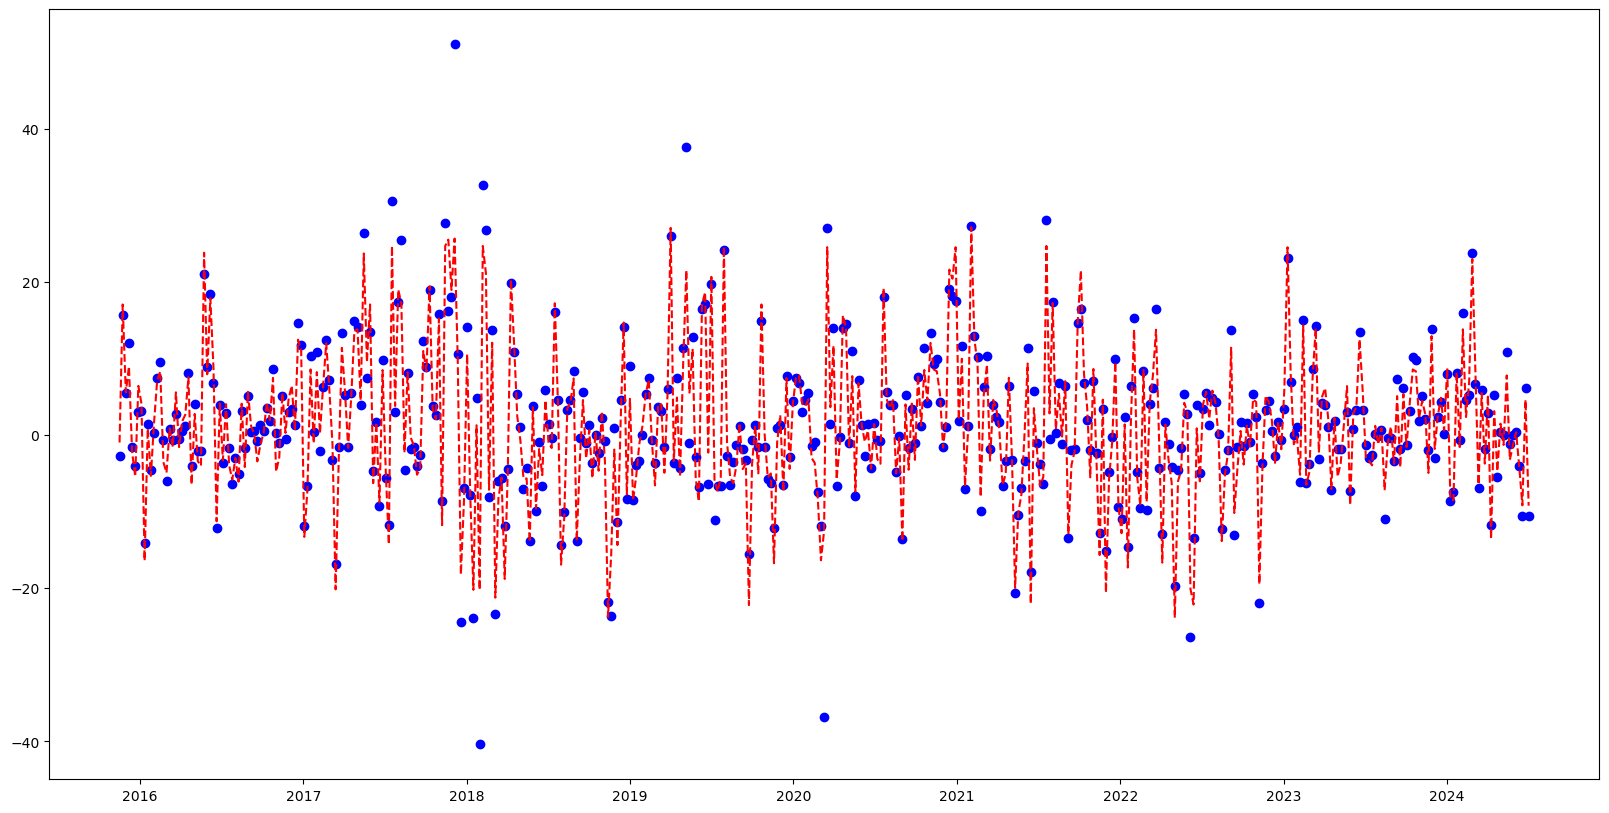

In [5]:
with warnings.catch_warnings():
    warnings.filterwarnings(action='ignore')
    pipeline.fit(X=X, y=y)
    y_pred = pipeline.predict(X)

fig, ax = plt.subplots(1, 1, figsize=(20, 10))
ax.scatter(btc['Date'], btc['target'], c='b')
ax.plot(btc['Date'], y_pred, c='r', linestyle='--')
fig.show()

In [6]:
print("----- MAE -----")
print(f"{mean_absolute_error(btc['target'], y_pred)}")
print("----- R2 ------")
print(f"{r2_score(btc['target'], y_pred)}")

----- MAE -----
1.7266774710488648
----- R2 ------
0.9136675015898941


In [7]:
print("---- Next Prediction ----")
print(pipeline.predict(X_pred.values.reshape(1, -1)))

---- Next Prediction ----
[-9.80811206]
